In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [17]:
from importlib import reload
import utils
reload(utils)

<module 'utils' from '/media/kirang/data/Documents/code/ocaml/domainslib/benchmarks/utils.py'>

### Run benchmarks

This function wraps around bench.exe to allow running `bench.exe` directly from python.

In [3]:
run_process = utils.run_process

Here's an example of its use and what it returns (a tuple of the time taken, and standard deviation of the measurement):

In [4]:
run_process("btree-explicitly", count=100)

(4e-05, 1e-05)

The `build_results` function allows running a series of inserts

In [5]:
build_results = utils.build_results

results = build_results(["btree-batched", "btree-coarse", "btree-sequential"], {'count': 100_000 })

  0%|          | 0/15 [00:00<?, ?it/s]

`build_results` takes in as its first parameter a list of tests, and the second parameter a dictionary describing any parameters to call `run_process` with.

The tests are either a name of data structure (such as `"btree-batched"`), or a dict with the fields:
 - 'name': name of the data structure (i.e "btree-batched")
 - 'label': a name used to uniquely identify the test case
 - 'title': a prettified description of the data series (used as the label)
and any other fields are passed as keyword arguments to the data structure


In [6]:
build_results([{'name': "btree-batched", 'label': 'btree-batched-10', 'title': "Btree with explicit batching (10 iters)", 'no_iters':10}], {'count': 1_000})

  0%|          | 0/15 [00:00<?, ?it/s]

[{'domains': 1, 'btree-batched-10': 0.00113, 'btree-batched-10-sd': 0.00025},
 {'domains': 2, 'btree-batched-10': 0.00108, 'btree-batched-10-sd': 0.00035},
 {'domains': 3, 'btree-batched-10': 0.00137, 'btree-batched-10-sd': 0.00023},
 {'domains': 4, 'btree-batched-10': 0.00159, 'btree-batched-10-sd': 0.00038},
 {'domains': 5, 'btree-batched-10': 0.00129, 'btree-batched-10-sd': 0.0003},
 {'domains': 6, 'btree-batched-10': 0.00152, 'btree-batched-10-sd': 0.00027},
 {'domains': 7, 'btree-batched-10': 0.00169, 'btree-batched-10-sd': 0.00027},
 {'domains': 8, 'btree-batched-10': 0.00173, 'btree-batched-10-sd': 0.0002},
 {'domains': 9, 'btree-batched-10': 0.00173, 'btree-batched-10-sd': 0.00028},
 {'domains': 10, 'btree-batched-10': 0.0018, 'btree-batched-10-sd': 0.00026},
 {'domains': 11, 'btree-batched-10': 0.00187, 'btree-batched-10-sd': 0.00025},
 {'domains': 12, 'btree-batched-10': 0.00255, 'btree-batched-10-sd': 0.00213},
 {'domains': 13, 'btree-batched-10': 0.00186, 'btree-batched-10-

We can plot results from `build_results` using the `plot_results` function:

In [7]:
plot_results = utils.plot_results   

The parameters are:
 1. the name of the parameter being tested
 2. a list of data structures, the same list that was passed to build_results
 3. the results returned by build_results

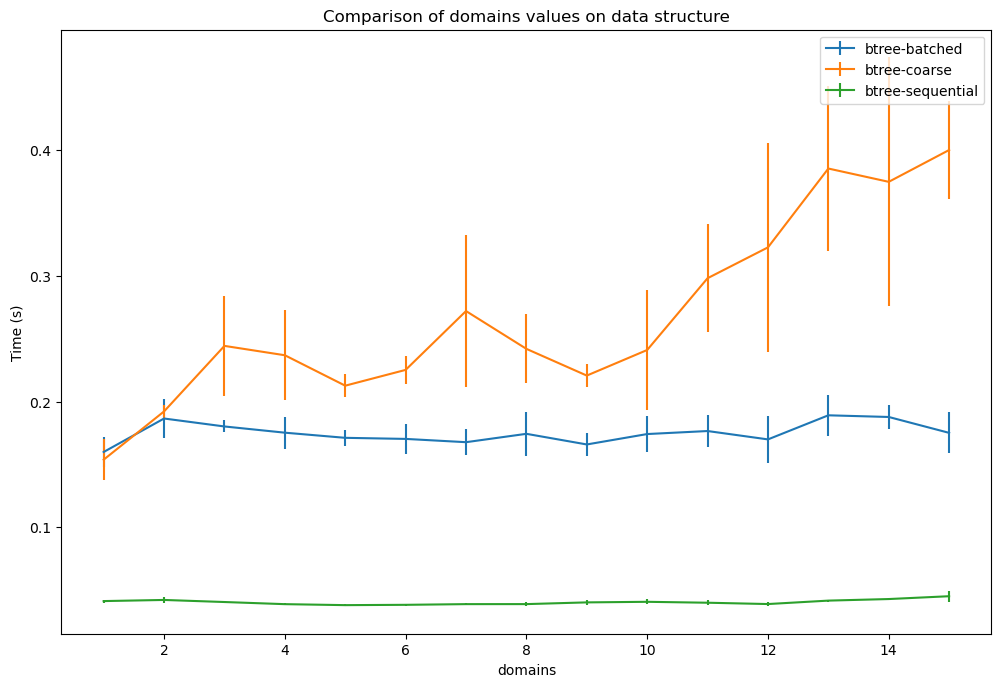

In [8]:
plot_results('domains', ["btree-batched", "btree-coarse", "btree-sequential"], results)

The above assumes a batched workflow, where we run all the tests at once, and then plot results.

When debugging, it is more useful to show intermediate results as they are generated.

We can use `utils.interactive_plot` for this:

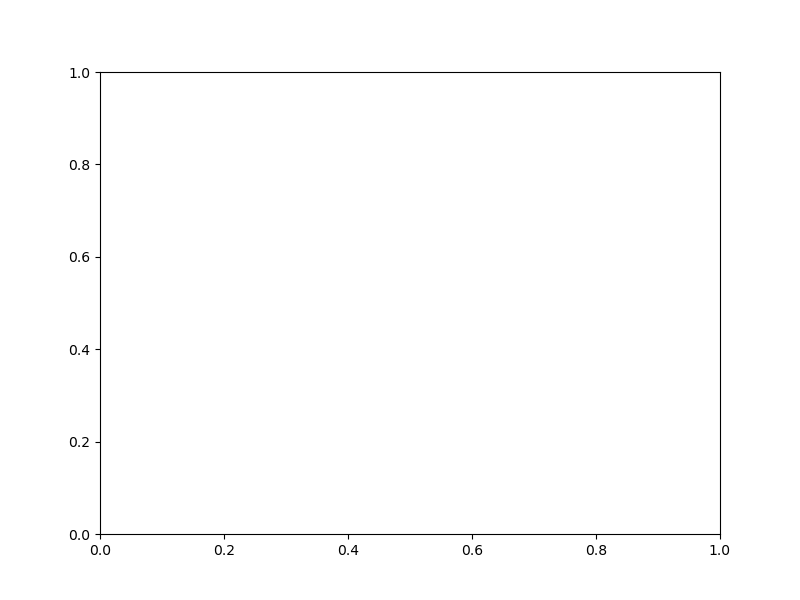

In [9]:
%matplotlib widget
import time
fig, ax = utils.interactive_plot()

In [23]:
data_structures = [
    {'name':'btree-sequential', 'label':'btree-sequential-unsorted', 'title': 'Btree Sequential (unsorted)'},
    {'name': 'btree-sequential', 'label': 'btree-sequential-sorted', 'title': 'Btree Sequential (sorted)', 'sorted': True},
    {'name': 'btree-explicit', 'label': 'btree-explicit-batched', 'title': 'Btree explicitly batched'},
]

_,  results = utils.build_interactive_plot(fig, ax, data_structures, {'count': 100_000})

In [78]:
data_structures=['btree-sequential', 'btree-explicit']
params={'count': 100_000, 'init_count': 100_000, 'validate': True }
times=[]
results=[]


for i in range(1, 16):
    result={'domains': i}
    times.append(i)
    results.append(result)
    for data_structure in data_structures:
        t,var = run_process(data_structure,**params)
        result[data_structure]=t
        result[data_structure+'-var']=var
        
        ax.clear()
        ax.set_title("Comparison of Sequential vs. our parallel insert")
        ax.set_xlabel('No. Domains')
        ax.set_ylabel('Time (s)')
        for data_structure in data_structures:
            available_values=[data[data_structure] for data in results if data_structure in data]
            available_var=[data[data_structure+'-var'] for data in results if (data_structure+'-var') in data]
            available_times=times[:len(available_values)]
            ax.errorbar(available_times, available_values, yerr=available_var, label=data_structure)
        ax.legend()
        fig.canvas.draw()

In [42]:
results

[]

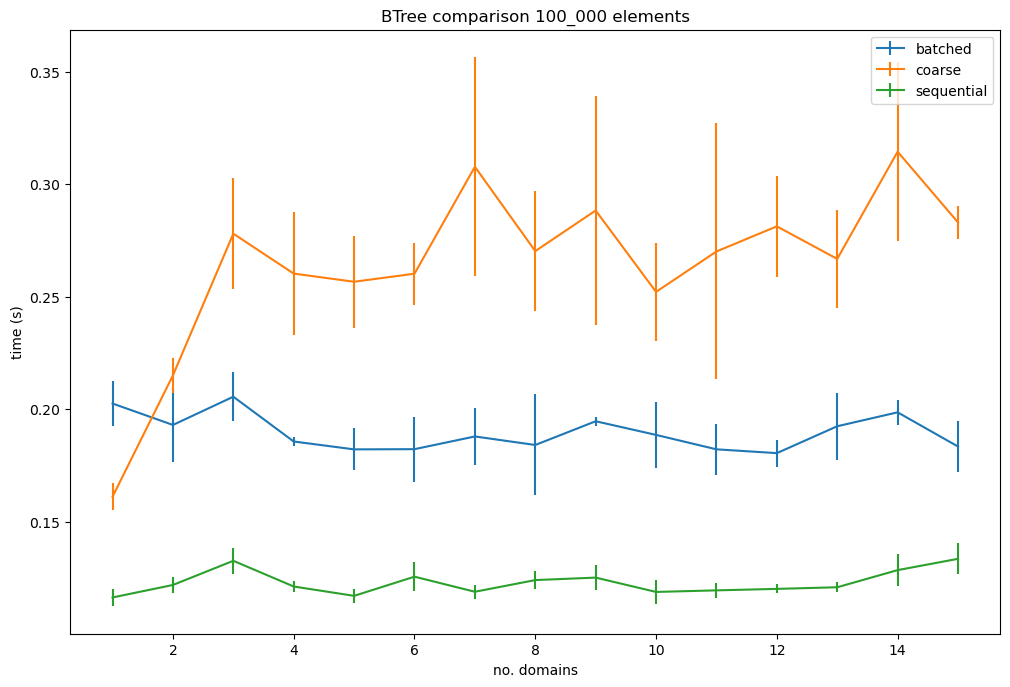

In [90]:
fig = plt.figure(figsize=(12,8), dpi=100, facecolor='w', edgecolor='k')
plt.errorbar(times, batched, yerr=[data['batched_var'] for data in results], label="batched")
plt.errorbar(times, coarse, yerr=[data['coarse_var'] for data in results], label="coarse")
plt.errorbar(times, sequential, yerr=[data['sequential_var'] for data in results], label="sequential")
plt.title('BTree comparison 100_000 elements')
plt.xlabel('no. domains')
plt.ylabel('time (s)')
plt.legend()
plt.show()

In [85]:
results

[{'domains': 1,
  'batched': 0.20259,
  'batched_var': 0.01006,
  'coarse': 0.16116,
  'coarse_var': 0.00594,
  'sequential': 0.11638,
  'sequential_var': 0.00391},
 {'domains': 2,
  'batched': 0.19307,
  'batched_var': 0.01639,
  'coarse': 0.21511,
  'coarse_var': 0.0077,
  'sequential': 0.12194,
  'sequential_var': 0.00347},
 {'domains': 3,
  'batched': 0.20562,
  'batched_var': 0.0109,
  'coarse': 0.27809,
  'coarse_var': 0.02461,
  'sequential': 0.13268,
  'sequential_var': 0.00572},
 {'domains': 4,
  'batched': 0.18571,
  'batched_var': 0.00213,
  'coarse': 0.26034,
  'coarse_var': 0.02716,
  'sequential': 0.12126,
  'sequential_var': 0.00251},
 {'domains': 5,
  'batched': 0.18221,
  'batched_var': 0.00936,
  'coarse': 0.25672,
  'coarse_var': 0.02037,
  'sequential': 0.1171,
  'sequential_var': 0.00319},
 {'domains': 6,
  'batched': 0.1823,
  'batched_var': 0.01443,
  'coarse': 0.26029,
  'coarse_var': 0.01385,
  'sequential': 0.12562,
  'sequential_var': 0.00647},
 {'domains': 7